In [16]:
from setup import *

adjacency_data = pd.DataFrame.from_csv('adjacency.csv')
adjacency_data.index = adjacency_data.index.str.lower()
adjacency_data.columns = adjacency_data.columns.str.lower()

judge_data = pd.DataFrame.from_csv('judges.csv')
project_data = pd.DataFrame.from_csv('projects.csv')
def make_df(data):
    df = pd.DataFrame()
    df['name'] = (data['LAST NAME'] + ', ' + data['FIRST NAME']).str.lower()
    df['univ'] = data['INSTITUTION'].str.lower().astype('category')
    df['cat'] = data['CATEGORY'].str.lower().astype('category')
    df['field'] = data['SUBFIELD'].str.lower().astype('category')        
    return df.sort_values('field')

judges = make_df(judge_data)
judges.index.names = ['judge id']
judges['mobile'] = judge_data['MOBILE COMFORT LEVEL']
projects = make_df(project_data)
projects.index.names = ['proj id']
projects['type'] = project_data['PRESENTATION TYPE']

projects.sort_values(['field'],inplace=True)
judges.sort_values(['field'],inplace=True)
    
### Compute field distance matrix
def show():
    print()
    print("k=%d"%k)
    print("P")
    display(P,'all')
    print("dist")
    display(dist,'all')

D = adjacency_data.copy().values.astype(int)
T = adjacency_data.copy().values.astype(float)
s = T.sum(axis=1, keepdims=True)
T /= s
P = T.copy()

k = 1
for k in range(2,50):
    P = P.dot(T)
    # Write k in all entries of D that are 0 and the corresponding entry of P just became non-zero
    D[((D==0) & (P>0))] = k
    if(D.min() > 0): #break once Dist is full
        break
D[D==0] = 999
D[np.diag_indices_from(D)] = 0

dist = adjacency_data.copy()
dist[:] = D
dist.loc[:,'doctoral'] = np.nan
dist.loc['doctoral',:] = np.nan

field_incompat = np.array([[dist.loc[jf,pf] for pf in projects['field']] for jf in judges['field']]).astype(float)
univ_match = np.array([[ju == pu for pu in projects['univ']] for ju in judges['univ']])
field_incompat[univ_match] = np.nan
field_incompat = pd.DataFrame(field_incompat, index=judges.index, columns=projects.index)

poster_idx = projects['type'] == 'Poster Presentation'
projects.loc[poster_idx,'type'] = 'poster'
posters = projects.loc[poster_idx].copy()

oral_idx = projects['type'] == 'Oral Presentation (Undergraduate and Masters Social Sciences Only)'
projects.loc[oral_idx,'type'] = 'oral'
orals = projects.loc[oral_idx].copy()

doc_idx = projects['type'] == 'Doctoral - Lightning Round Oral Presentation Competition'
projects.loc[doc_idx,'type'] = 'doctoral'
docs = projects.loc[doc_idx].copy()

def f(x):
    y = x.value_counts(sort=True)
    y = y[y>0]
    y.sort_values()
    return y

pf = projects.groupby('field')['type'].apply(f).unstack()
pf['total'] = pf.sum(axis=1)
jf = f(judges['field'])
jf.name = 'judges'
pjf = pd.concat([pf,jf],axis=1).fillna(0).astype('int')

# display(dist,'all')
# display(field_incompat)

# display(posters.groupby('field')['cat'].apply(f),'all')
# display(projects.groupby(['type','cat'])['field'].apply(f),'all')
# display(pjf,'all')

inc_judge_cost = True
num_sessions = 4
workload = 5
coverage = 3

posters_to_sessions_attempts = 30
judges_to_posters_attempts = 3


num_judges = len(judges)
num_posters = len(posters)
fi_best = 99999

poster_grps = posters.groupby(['field'])
blank =  {'posters_to_sessions': []
         ,'judges_to_posters' : [[]]*num_sessions
         ,'fi':[99999]*num_sessions
         }
blank['fi_tot'] = sum(blank['fi'])
best = copy.deepcopy(blank)
for ps in range(posters_to_sessions_attempts):
#     print("posters to session attempt %d"%ps)
    curr = copy.deepcopy(blank)
    curr['posters_to_sessions'] = poster_grps.transform(lambda x: np.random.permutation(x))#.join(projs[['atype','field']])    
    curr['posters_to_sessions'] = pd.concat([curr['posters_to_sessions'],posters['field']],axis=1)
    curr['posters_to_sessions']['ses'] = np.arange(num_posters) % num_sessions

    for ses in range(num_sessions):
#         print("    optimizing session %d"%ses)
        post = curr['posters_to_sessions'].query('ses == @ses')

        fi_source = field_incompat.loc[:, post.index]
        for jp in range(judges_to_posters_attempts):
#             print("        judges to posters attempt %d"%jp)
            
            assign = fi_source.copy()
            assign[:] = np.nan
            fi_rec = fi_source.copy()

            judge_work = assign.iloc[:,0].copy()
            judge_work[:] = workload
            judge_work = judge_work.astype(int)
            
            poster_coverage = assign.iloc[0,:].copy()
            poster_coverage[:] = coverage
            poster_coverage = poster_coverage.astype(int)
            
            while True:
                urgency = fi_rec.mean(axis=0, skipna=True)
                urg_max = urgency.max(skipna=True)
                if(np.isnan(urg_max) == True):
#                     print("no posters left")
                    break
                urg_post = urgency[urgency >= urg_max].index
                if(len(urg_post) == 1):
                    urg_post = urg_post[0]
                else:
                    urg_post = np.random.choice(urg_post)
                col = fi_rec[urg_post]
                fi_min = col.min(skipna=True)
                if(np.isnan(fi_min) == True):
#                     print("no judges left")
                    break
        
                best_judge = col[col <= fi_min].index
                if(len(best_judge) == 1):
                    best_judge = best_judge[0]
                else:
                    best_judge = np.random.choice(best_judge)
                    
                assign.loc[best_judge,urg_post] = fi_rec.loc[best_judge,urg_post]
                
                if(inc_judge_cost == True):
                    fi_rec.loc[best_judge,:] += 1
                fi_rec.loc[best_judge,urg_post] = np.nan

                poster_coverage[urg_post] -= 1
                if(poster_coverage[urg_post] <= 0):
                    fi_rec.loc[:,urg_post] = np.nan

                judge_work.loc[best_judge] -= 1
                if(judge_work[best_judge] <= 0):
                    fi_rec.loc[best_judge,:] = np.nan

                


            fi_ses = np.nansum(assign)
#             print("        completed judge to proj %d"%jp)
#             print("        new fi_ses = %f"%fi_ses)
            if(fi_ses < curr['fi'][ses]):
#                 print("        better than old fi_ses_best = %f"%curr['fi'][ses])
                curr['fi'][ses] = fi_ses
                curr['judges_to_posters'][ses] = assign
#             else:
#                 print("        not better than old fi_ses_best = %f"%curr['fi'][ses])
#             print()
    curr['fi_tot'] = sum(curr['fi'])
#     print("    completed posters to sessions %d"%ps)
    print("    new fi_tot = %f"%curr['fi_tot'])    
    if(curr['fi_tot'] < best['fi_tot']):
        print("    better than old fi_tot best = %f"%best['fi_tot'])
        best = copy.deepcopy(curr)
    else:
        print("    not better than old fi_best = %f"%best['fi_tot'])        

    new fi_tot = 645.000000
    better than old fi_tot best = 399996.000000
    new fi_tot = 627.000000
    better than old fi_tot best = 645.000000
    new fi_tot = 629.000000
    not better than old fi_best = 627.000000
    new fi_tot = 635.000000
    not better than old fi_best = 627.000000
    new fi_tot = 624.000000
    better than old fi_tot best = 627.000000
    new fi_tot = 620.000000
    better than old fi_tot best = 624.000000
    new fi_tot = 629.000000
    not better than old fi_best = 620.000000
    new fi_tot = 633.000000
    not better than old fi_best = 620.000000
    new fi_tot = 631.000000
    not better than old fi_best = 620.000000
    new fi_tot = 641.000000
    not better than old fi_best = 620.000000
    new fi_tot = 635.000000
    not better than old fi_best = 620.000000
    new fi_tot = 629.000000
    not better than old fi_best = 620.000000
    new fi_tot = 629.000000
    not better than old fi_best = 620.000000
    new fi_tot = 628.000000
    not better than 

In [6]:
def get_assign(col):
    x = pd.Series(col.dropna().index)
    return x
poster_assign = pd.concat([jp.T.apply(get_assign,axis=1).rename(columns = lambda x : 'judge_' + str(x)) for jp in best['judges_to_posters']])
poster_fi = pd.concat([jp.sum(axis=0) for jp in best['judges_to_posters']]).astype(int)
poster_fi.name = 'field_incompat'

attrs = ['ses','name','univ','field']
poster_pairings = best['posters_to_sessions'].loc[poster_assign.index,attrs]
attrs.remove('ses')
jud = pd.concat([judges.loc[col[1],attrs].reset_index() for col in poster_assign.items()], axis=1)
jud.index = poster_pairings.index
poster_pairings = pd.concat([poster_pairings,poster_fi,jud],axis=1).sort_values('field_incompat',ascending=False)
display(poster_pairings.iloc[:20])


judges_assign = [jp.apply(get_assign,axis=1).rename(columns = lambda x : 'post_' + str(x)) for jp in best['judges_to_posters']]
for (ses,ja) in enumerate(judges_assign):
    name = 'work_'+str(ses)
    col = ja.count(axis=1)
    judges_assign[ses][name] = name
    judges[name] = col
judges['work_tot'] = judges['work_0']+judges['work_1']+judges['work_2']+judges['work_3']

cols = judges.columns.tolist()
cols[4], cols[-1] = cols[-1], cols[4]
judges = judges[cols].sort_values('work_tot',ascending=False)
display(judges.iloc[:20])


,ses,name,univ,field,field_incompat,judge id,name,univ,field,judge id,name,univ,field,judge id,name,univ,field
proj id,,,,,,,,,,,,,,,,,
R_2YJQ5wjXFH7CR00,0,"badmus, olatunde",prairie view a&m university,"geosciences, geology, hydrology, geophysics",7,R_3h4Pu7PsHMWGw3q,"muir, james",texas a&m university - college station,agriculture,R_VU7Lb4Fiqa8zGoN,"mccuistion, kim",texas a&m university - kingsville,"animal science, poultry science",R_1FETrLE2PmkRdk2,"awal, ripendra",prairie view a&m university,"geosciences, geology, hydrology, geophysics"
R_3O1FI6Brt9kzgGf,3,"crews, sydney",prairie view a&m university,chemistry,6,R_2qCVLHWhdCvDkPY,"quaid, brandon",texas a&m university - texarkana,biology,R_syZDasKuSfQMQ4F,"lewis, sally",tarleton state university,biomedical sciences,R_28AHV79JuU0zwUW,"srinivasan, rajani",tarleton state university,chemistry
R_1mygmhObIpIDAhg,2,"potluri, sai pradeep",texas a&m university - kingsville,"engineering - environmental, biological, agric...",6,R_28AHV79JuU0zwUW,"srinivasan, rajani",tarleton state university,chemistry,R_1pEwVDWQkquWmHZ,"huang, arthur",tarleton state university,engineering - civil,R_1H2B2wF9Ujo4e7Y,"albert, lynal",tarleton state university,"engineering - environmental, biological, agric..."
R_2yd26mFqMyYKbM4,1,"shah, niral",texas a&m university - kingsville,"engineering - environmental, biological, agric...",6,R_8HrvMsXFeqqdgtj,"ryou, myoung-gwi",tarleton state university,biomedical sciences,R_1Pcwjkecr8aAIgo,"shakir, safwat",prairie view a&m university,"engineering - environmental, biological, agric...",R_3t67LHtEL090nwF,"mcfarland, anne",tarleton state university,environmental studies - soil sciences
R_237E9KdVoxdj2jh,1,"garcia, jose",texas a&m university - kingsville,"engineering - environmental, biological, agric...",6,R_2RNSrbXChtFZiiS,"moreira, rosana",texas a&m university - college station,"engineering - environmental, biological, agric...",R_2xxTyaVDFnDzpjt,"goderya, shaukat",tarleton state university,physics,R_1rANHDWIJ6SmhXO,"kafley, hemanta",tarleton state university,wildlife & fisheries management science
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_2QSd70cu3D9qgt2,2,"mills, kira",tarleton state university,chemistry,6,R_syZDasKuSfQMQ4F,"lewis, sally",tarleton state university,biomedical sciences,R_8HrvMsXFeqqdgtj,"ryou, myoung-gwi",tarleton state university,biomedical sciences,R_1C7s8AwuPbSwnHE,"chiu, weihsueh",texas a&m university - college station,"health - public, human"
R_1LciRw7hFosUOJD,3,"armah, esther",prairie view a&m university,"engineering - environmental, biological, agric...",6,R_1pEwVDWQkquWmHZ,"huang, arthur",tarleton state university,engineering - civil,R_2QEZB30H8QgOBtg,"venkataraman, kartik",tarleton state university,"engineering - environmental, biological, agric...",R_2RNSrbXChtFZiiS,"moreira, rosana",texas a&m university - college station,"engineering - environmental, biological, agric..."
R_2DP9r8DDq8rvgmN,2,"castro, joshua",tarleton state university,biomedical sciences,6,R_1C7s8AwuPbSwnHE,"chiu, weihsueh",texas a&m university - college station,"health - public, human",R_21GnfBZ5QXIx75W,"tietjen-smith, tara",texas a&m university - commerce,"health - public, human",R_2dmQS4dtNsX2Wsu,"kilburn, john",texas a&m international university,organizational behavior


,name,univ,cat,field,work_tot,work_0,work_1,work_2,work_3,mobile
judge id,,,,,,,,,,
R_1FETrLE2PmkRdk2,"awal, ripendra",prairie view a&m university,agriculture,"geosciences, geology, hydrology, geophysics",12,3,3,3,3,Yes
R_2qCVLHWhdCvDkPY,"quaid, brandon",texas a&m university - texarkana,life science,biology,12,3,3,3,3,Yes
R_qVmiVRWiX1daU5r,"schulze, anja",texas a&m university - galveston,life science,biology,11,3,2,3,3,Yes
R_2RNSrbXChtFZiiS,"moreira, rosana",texas a&m university - college station,agriculture,"engineering - environmental, biological, agric...",11,2,3,3,3,Yes
R_3r2IXneTMK5n0Ci,"chraibi, victoria",tarleton state university,environmental science,biology,11,2,3,3,3,Yes
...,...,...,...,...,...,...,...,...,...,...
R_3fV7Jg4bBLqspgB,"fan, huajun",prairie view a&m university,physical science,chemistry,9,3,2,2,2,Yes
R_2cB1mU5QVJoGmLb,"kunta, madhurababu",texas a&m university - kingsville,agriculture,biology,9,2,2,2,3,Yes
R_OIKjhEVOmcbjWq5,"ross, corinna",texas a&m university - san antonio,life science,biology,9,3,2,2,2,Yes


Field Incompatibilty by poster


,field_incompat
count,187.000
mean,3.316
std,1.757
min,0.000
25%,2.000
50%,3.000
75%,5.000
max,7.000


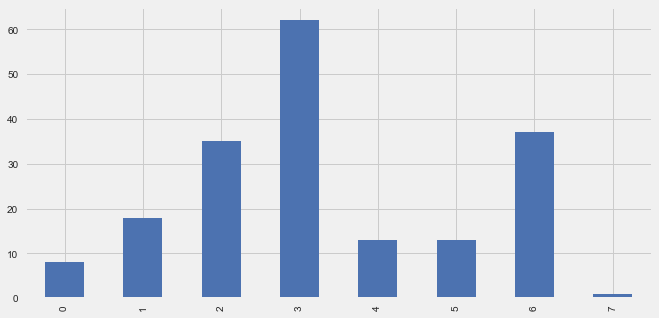

Workload by Judge


,work_tot
count,94.000
mean,5.968
std,3.342
min,0.000
25%,4.000
50%,7.000
75%,8.000
max,12.000


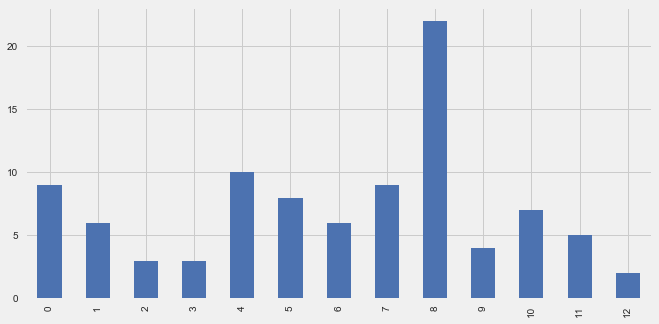

In [15]:
print("Field Incompatibilty by poster")
fig, ax = plt.subplots()
dat = poster_fi
display(dat.describe())
pd.value_counts(dat,sort=False).plot(kind="bar")
plt.show()


print("Workload by Judge")
fig, ax = plt.subplots(1,1)
dat = judges['work_tot']
display(dat.describe())
pd.value_counts(dat,sort=False).plot(kind="bar")
plt.show()

